# Train a simple image classifier

**Task**: Train a flower classifier.

Outline:

1. Load the data
    1. Download the dataset.
    2. Set up the dataloaders (which handles train-validation split, batching, and resizing)
2. Train a model
    1. Get a foundation model (an EfficentNet in our case)
    2. Fine-tune it.
3. Get the model's predictions on an image.

This notebook includes tasks (marked with "**Task**") and blank code cells (labeled `# your code here`) to fill in your answers.

## Setup

**Press the play button below to run this code.** (You do not need to read or modify the code in this section to successfully complete this assignment.)

In [6]:
# Install PyTorch and TorchVision (if not already installed or if using a specific CUDA version)
# Colab often has PyTorch pre-installed, but torchvision might need explicit installation.
# This command is for CUDA 12.1, common in Colab. Adjust if a different CUDA version is needed.
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [7]:
import random
import time
import os
import torch
import torchvision
import numpy as np
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, HTML
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm # for progress bars

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
num_gpus = torch.cuda.device_count()
print(f"GPUs available: {num_gpus}")
if num_gpus == 0:
    from IPython.display import display, HTML
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))


PyTorch version: 2.9.0+cu126
TorchVision version: 0.24.0+cu126
GPUs available: 1


In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [9]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to denormalize and convert tensor to image for display
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W to H x W x C
    mean = data_transforms.mean #np.array([0.485, 0.456, 0.406])
    std = data_transforms.std #np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Clip values to [0, 1]
    if ax is None:
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(inp)
        if title is not None:
            ax.set_title(title)
        ax.axis('off')



## Configure our experiments

You'll be invited to change parameters in this code block later; for now just run it as-is.

In [10]:
# How much of the dataset to hold out for validation
VALIDATION_FRAC = 0.2

# Other configuration
class config:
    seed = 312
    learning_rate = 1e-3
    epochs = 1
    batch_size = 32
    image_size = 256
    pretrained_weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 # pretrained on ImageNet 1k

In [20]:
# Set a seed so that the results are the same every time this is run.
set_seed(config.seed)


### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [11]:
import urllib.request
import tarfile
from pathlib import Path

# Define the URL and local path
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# Create a directory to store the downloaded and extracted data
download_dir = Path("./data")
download_dir.mkdir(parents=True, exist_ok=True)
archive_path = download_dir / "flower_photos.tgz"
extract_path = download_dir / "flower_photos"

# Download the file if it doesn't exist
if not archive_path.exists():
    print(f"Downloading {url} to {archive_path}...")
    urllib.request.urlretrieve(url, archive_path)
    print("Download complete.")

# Extract the file if the extracted directory doesn't exist
if not extract_path.exists():
    print(f"Extracting {archive_path} to {extract_path}...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=download_dir)
    print("Extraction complete.")

data_path = extract_path
print(f"Data path set to: {data_path}")

Download complete.
Extracting data/flower_photos.tgz to data/flower_photos...


/tmp/ipython-input-1475508018.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=download_dir)


Extraction complete.
Data path set to: data/flower_photos


Let's see what just got downloaded.

In [12]:
!ls {data_path}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [13]:
# Define how we turn an image into an input for a neural net.
# The default is to resize, center crop, convert data storage types, and then normalize
data_transforms = config.pretrained_weights.transforms(crop_size=config.image_size)

# Load the dataset
full_dataset = datasets.ImageFolder(
    root=data_path,
    transform=data_transforms
)

class_names = full_dataset.classes

# Split the dataset into training and validation sets
val_size = int(VALIDATION_FRAC * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(config.seed)
)

# Create data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=os.cpu_count() // 2 if os.cpu_count() else 0 # Use half of available CPU cores for data loading
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=os.cpu_count() // 2 if os.cpu_count() else 0
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 2936
Number of validation samples: 734


### Example Images

Here's what one "batch" of training data looks like:

Class names in order: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


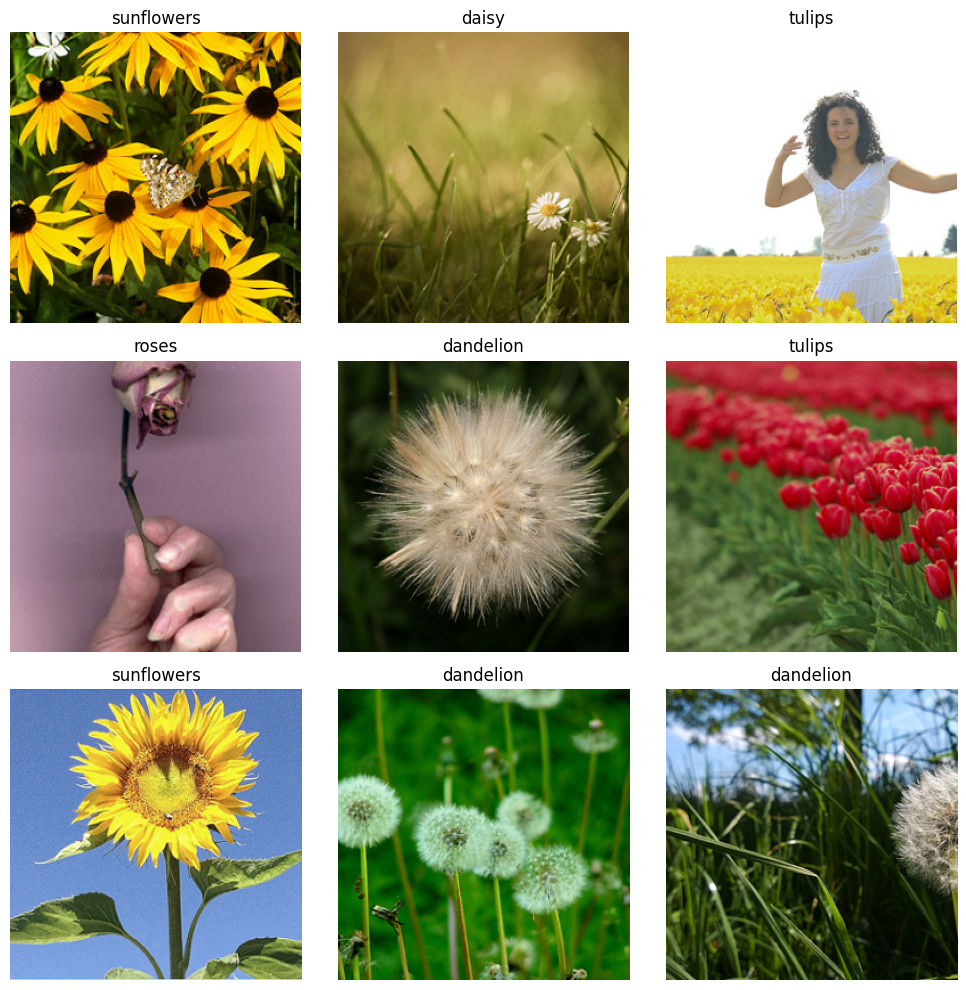

In [14]:
print(f"Class names in order: {class_names}")

# Get a batch of training data
# iter() creates an iterator from the DataLoader
# next() gets the next item from the iterator (which is a batch)
inputs, classes = next(iter(train_dataloader))

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    if i < len(inputs): # Ensure we don't go out of bounds if batch size is less than 9
        imshow(inputs[i].cpu(), title=class_names[classes[i]], ax=ax)
plt.tight_layout()
plt.show()

### Train a model

We'll unpack this code over the next several weeks. For now, just pay attention to the output.

In [15]:
# Create a model using a pretrained backbone
# Load an EfficientNet model that has been pre-trained on ImageNet
model = models.efficientnet_b0(weights=config.pretrained_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


In [16]:
%%time

# Modify the classifier head for our number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, len(class_names))

# Move the model to the appropriate device (GPU if available, else CPU)
model = model.to(device);

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Define a simple training function (this would typically be more elaborate)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=config.epochs):
    since = time.time()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_losses_per_step': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with a progress bar
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                # We only need gradients during the training phase.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        history['train_losses_per_step'].append(loss.item()) # Track loss per step

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    return model, history

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=config.epochs)


Epoch 0/0
----------


train Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

train Loss: 0.4446 Acc: 0.8529


val Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

val Loss: 0.3025 Acc: 0.8978

CPU times: user 15.8 s, sys: 1.18 s, total: 17 s
Wall time: 31.5 s


You'll see **accuracy** (fraction correct, e.g., accuracy = 0.5 means it got half of the answers correct, i.e., 50%) and **loss** (which gives partial credit based on confidence). We'll study these more in coming weeks!

**Task**: Fill in the table below, using the output above:

- Training set accuracy: 81.74%
- Validation set accuracy: 89.51%
- Training loss: 55.19%
- Validation loss: 28.84%

### Make some predictions

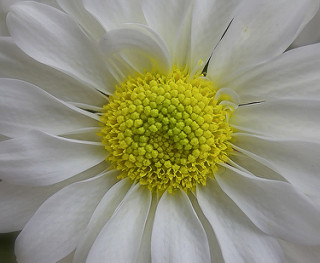

In [28]:
# Load an image from the local dataset
image_path = Path('data/flower_photos/daisy/100080576_f52e8ee070_n.jpg')
image = Image.open(image_path).convert('RGB')

# Apply the same transformations as the training data
input_tensor = data_transforms(image).unsqueeze(0) # Add batch dimension

display(image)

In [29]:
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    input_tensor = input_tensor.to(device)
    outputs = model(input_tensor)
    probabilities = outputs[0].softmax(dim=0).cpu().numpy()

pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

,class,prob
0,daisy,0.879796
2,roses,0.045841
1,dandelion,0.031957
4,tulips,0.025519
3,sunflowers,0.016888


**Task**: Is the second column a valid probability distribution (ignoring round-off errors)? Describe why or why not.

*Yes, because the sum of the values in the probability column is equal to one.*

**Task**: Write code to show the category with the highest predicted probability. To do this, use the `np.argmax` function and the `class_names` list.

*Hint*: look at the value of the `probabilities` variable by making a code chunk with just `probabilities` in it.

In [ ]:
predicted_class_idx = np.argmax(...)
predicted_class_name = class_names[...]
print(f"The predicted category with the highest probability is: {predicted_class_name}")

The predicted category with the highest probability is: daisy


## Experimentation

Try changing one parameter in the `config` code block above and rerun the notebook. What effect does this have on the validation accuracy? (Run the same parameters a few times with different values for `config.seed` to check if the result is robust.)

*Dividing the batch_size in half to a value of 32 will raise the training accuracy by about 5%, and raise the validation accuracy by about 1%. If we then Changing the seed does not dramatically change the results after that.*


## Optional extension: try out your own image

Finish the code below to be able to try out the classifier on your own image.

In [ ]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
from PIL import Image

if len(uploader.data) > 0:
    image_file = io.BytesIO(uploader.data[0])
    image = Image.open(image_file).convert('RGB')
    display(image)

    # Apply inference transformations
    inference_transforms = transforms.Compose([
        transforms.Resize(config.image_size),
        transforms.CenterCrop(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = inference_transforms(image).unsqueeze(0) # Add batch dimension

    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        input_tensor = input_tensor.to(device)
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()

    # Display predictions
    display(pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False))

    # Show the most likely class
    predicted_class_idx = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_idx]
    print(f"The predicted category for the uploaded image is: {predicted_class_name}")
